In [30]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.utils import Sequence
from PIL import UnidentifiedImageError
import tensorflow as tf

In [35]:
# Define paths
train_data_dir = 'data/cats_dogs'
validation_data_dir = 'data/cats_dogs'
img_width, img_height = 224, 224
batch_size = 32

# Custom data generator to handle unidentified images
class SafeDataGenerator(Sequence):
    def __init__(self, generator):
        self.generator = generator
        self.valid_indices = self._filter_valid_indices()

    def _filter_valid_indices(self):
        valid_indices = []
        for i in range(len(self.generator)):
            try:
                _ = self.generator[i]
                valid_indices.append(i)
            except (UnidentifiedImageError, tf.errors.InvalidArgumentError):
                continue
        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, index):
        valid_index = self.valid_indices[index]
        return self.generator[valid_index]

# Data augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')  # set as training data

validation_generator = train_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')  # set as validation data

# Wrap the original generators with SafeDataGenerator
safe_train_generator = SafeDataGenerator(train_generator)
safe_validation_generator = SafeDataGenerator(validation_generator)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [57]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    safe_train_generator,
    steps_per_epoch=len(safe_train_generator),
    validation_data=safe_validation_generator,
    validation_steps=len(safe_validation_generator),
    epochs=10)

Epoch 1/10
560/624 ━━━━━━━━━━━━━━━━━━━━ 29s 463ms/step - accuracy: 0.6302 - loss: 0.6449

c:\Users\leeyo\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


624/624 ━━━━━━━━━━━━━━━━━━━━ 362s 576ms/step - accuracy: 0.6303 - loss: 0.6446 - val_accuracy: 0.6121 - val_loss: 0.6476
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


c:\Users\leeyo\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


624/624 ━━━━━━━━━━━━━━━━━━━━ 357s 572ms/step - accuracy: 0.6386 - loss: 0.6399 - val_accuracy: 0.6373 - val_loss: 0.6366
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 46us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 357s 572ms/step - accuracy: 0.6417 - loss: 0.6303 - val_accuracy: 0.6451 - val_loss: 0.6275
Epoch 6/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 47us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 357s 571ms/step - accuracy: 0.6414 - loss: 0.6315 - val_accuracy: 0.6616 - val_loss: 0.6184
Epoch 8/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 46us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 356s 570ms/step - accuracy: 0.6487 - loss: 0.6237 - val_accuracy: 0.6324 - val_loss: 0.6351
Epoch 10/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 43us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


In [58]:
# Show Accuracy
print(model.evaluate(safe_validation_generator))

156/156 ━━━━━━━━━━━━━━━━━━━━ 70s 450ms/step - accuracy: 0.6343 - loss: 0.6280
[0.6345891356468201, 0.6276167631149292]


In [59]:
# Save the model in the native Keras format
model.save('cats_dogs_resnet50.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Predicted: Dog
Actual: Dog


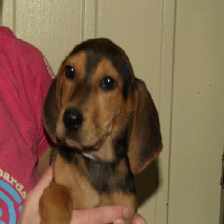

In [60]:
# load model
model = tf.keras.models.load_model('cats_dogs_resnet50.keras')

# Load a ranmdom image
import random

catsOrDogs = random.choice(["cats", "dogs"])
image_path = f"data/cats_dogs/{catsOrDogs}/{random.choice(os.listdir(f'data/cats_dogs/{catsOrDogs}'))}"

# Load the image
img = image.load_img(image_path, target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Predict the image
preds = model.predict(x)
print('Predicted:', "Dog" if preds[0][0] > 0.5 else "Cat")

# Actual
print('Actual:', "Dog" if catsOrDogs == "dogs" else "Cat")

img